## Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss

## Defining utilities

In [ ]:
def evaluate_and_display_confusion_matrix(model, X_test_raw_df, y_test_series, dropped_columns, model_type='Decision Tree', depth=None, print_and_plot=True):
    X_test_processed = X_test_raw_df.copy()

    X_test_processed = X_test_processed.drop(columns=dropped_columns, errors='ignore')

    y_pred = model.predict(X_test_processed)

    cm = confusion_matrix(y_test_series, y_pred)

    if print_and_plot:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Goal', 'Goal'])
        disp.plot(cmap=plt.cm.Blues)
        title_str = f'Confusion Matrix for {model_type} Model'
        if depth is not None:
            title_str += f' (depth = {depth})'
        plt.title(title_str)
        plt.show()

    accuracy = accuracy_score(y_test_series, y_pred)
    precision = precision_score(y_test_series, y_pred)
    recall = recall_score(y_test_series, y_pred)
    f1 = f1_score(y_test_series, y_pred)

    if print_and_plot:
        print(f"\nModel Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'confusion_matrix': cm}


## Loading and describing dataset

In [ ]:
drive.mount('/content/drive')

path = "/content/drive/My Drive/xG/"

X_train = pd.read_csv(path + "X_train_.csv")
X_test  = pd.read_csv(path + "X_test_.csv")
y_train = pd.read_csv(path + "y_train.csv")
y_test  = pd.read_csv(path + "y_test.csv")
xg = pd.read_csv(path + 'X_baseline.csv')

print("X_train info:")
X_train.info()
print("\nX_train description:")
print(X_train.describe().to_markdown(numalign="left", stralign="left"))

print("\ny_train info:")
y_train.info()
print("\ny_train description:")
print(y_train.describe().to_markdown(numalign="left", stralign="left"))

Mounted at /content/drive
X_train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   f1_dist_goal           6264 non-null   float64
 1   f2_angle_goal          6264 non-null   float64
 2   f3_dist_gk             6264 non-null   float64
 3   f4_centrality          6264 non-null   float64
 4   f5_pos_x               6264 non-null   float64
 5   f6_min_dist_def        6264 non-null   float64
 6   f7_pressure_effective  6264 non-null   int64  
 7   f8_pressure_possible   6264 non-null   int64  
 8   f9_min_dist_ra         6264 non-null   float64
 9   f10_blockers_traj      6264 non-null   int64  
 10  f12_gk_on_traj         6264 non-null   bool   
 11  f13_def_compactness    6264 non-null   float64
 12  tech_89.0              6264 non-null   int64  
 13  tech_90.0              6264 non-null   int64  
 14  tech_91.0       

### Dropping columns with average value of 0 from dataset

In [ ]:
print(f"Original X_train shape: {X_train.shape}")

zero_mean_columns = X_train.columns[X_train.mean() == 0].tolist()

if zero_mean_columns:
    print(f"\nColumns in X_train with an average value of 0: {zero_mean_columns}")
    X_train = X_train.drop(columns=zero_mean_columns)
    print(f"\nNew X_train shape after dropping columns: {X_train.shape}")
else:
    print("\nNo columns in X_train have an average value of 0.")

Original X_train shape: (6264, 27)

Columns in X_train with an average value of 0: ['tech_96.0', 'tech_97.0', 'tech_98.0', 'tech_100.0', 'body_46.0']

New X_train shape after dropping columns: (6264, 22)


## Training decision trees on dataset

Below, we train 16 different decision trees, each with a depth that ranges from 1 to 16, and compare their individual performances using various metrics, including ROC-AUC. We see that the tree that performed best as per the ROC-AUC metric is the one with a depth of 5.

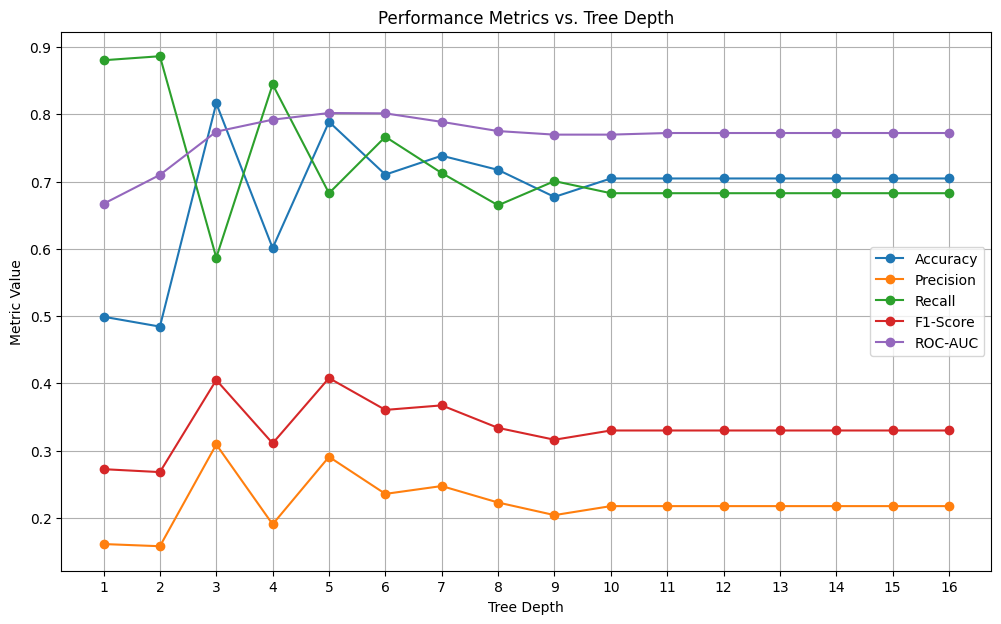

The tree depth with the best ROC-AUC is: 5
The ROC-AUC for the best tree is: 0.8018


In [ ]:
trees = []
tree_depths = [i for i in range(1,17)]  # 1 through 30

all_metrics = {
    'depth': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': []
}

X_test_original_for_loop = pd.read_csv(path + "X_test_.csv")

X_test_processed_for_loop = X_test_original_for_loop.drop(columns=zero_mean_columns, errors='ignore')

for d in tree_depths:
    dt_model_ = DecisionTreeClassifier(
        max_depth=d,
        random_state=42,
        class_weight='balanced',
        min_samples_leaf=50,
    )
    dt_model_.fit(X_train, y_train)
    trees.append(dt_model_)

    metrics = evaluate_and_display_confusion_matrix(
        model=dt_model_,
        X_test_raw_df=X_test_original_for_loop,
        y_test_series=y_test,
        dropped_columns=zero_mean_columns,
        model_type='Decision Tree',
        depth=d,
        print_and_plot=False
    )

    y_pred_proba = dt_model_.predict_proba(X_test_processed_for_loop)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    all_metrics['depth'].append(d)
    all_metrics['accuracy'].append(metrics['accuracy'])
    all_metrics['precision'].append(metrics['precision'])
    all_metrics['recall'].append(metrics['recall'])
    all_metrics['f1_score'].append(metrics['f1_score'])
    all_metrics['roc_auc'].append(roc_auc)

metrics_df = pd.DataFrame(all_metrics)

plt.figure(figsize=(12, 7))
plt.plot(metrics_df['depth'], metrics_df['accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df['depth'], metrics_df['precision'], marker='o', label='Precision')
plt.plot(metrics_df['depth'], metrics_df['recall'], marker='o', label='Recall')
plt.plot(metrics_df['depth'], metrics_df['f1_score'], marker='o', label='F1-Score')
plt.plot(metrics_df['depth'], metrics_df['roc_auc'], marker='o', label='ROC-AUC') # Plot ROC-AUC

plt.title('Performance Metrics vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Metric Value')
plt.xticks(tree_depths)
plt.grid(True)
plt.legend()
plt.show()

best_roc_auc_depth = metrics_df.loc[metrics_df['roc_auc'].idxmax(), 'depth']
print(f"The tree depth with the best ROC-AUC is: {best_roc_auc_depth}")
print(f"The ROC-AUC for the best tree is: {metrics_df.loc[metrics_df['roc_auc'].idxmax(), 'roc_auc']:.4f}")

Does PCA help? We find how many components explain about 98% of the variance (4).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# we find the first index where cumulative variance ratio is >= 0.98
n_components = np.where(cumulative_variance_ratio >= 0.98)[0][0] + 1

pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)

X_test_processed = X_test.drop(columns=zero_mean_columns, errors='ignore')
X_test_pca = pca.transform(X_test_processed)

print(f"Optimal number of components selected: {n_components}")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

Optimal number of components selected: 4
X_train_pca shape: (6264, 4)
X_test_pca shape: (1567, 4)


Then, we train a set of trees of varying depths just as before. We see that ROC-AUC is just shy of 0.8 at its peak, which occurs with a tree of depth 4 instead of 5. Another difference is that recall is slightly superior to that of the tree of depth 5 trained without PCA, while the accuracy is slightly inferior. This means the model will correctly classify more goals, but incorrectly classify more non-goals.

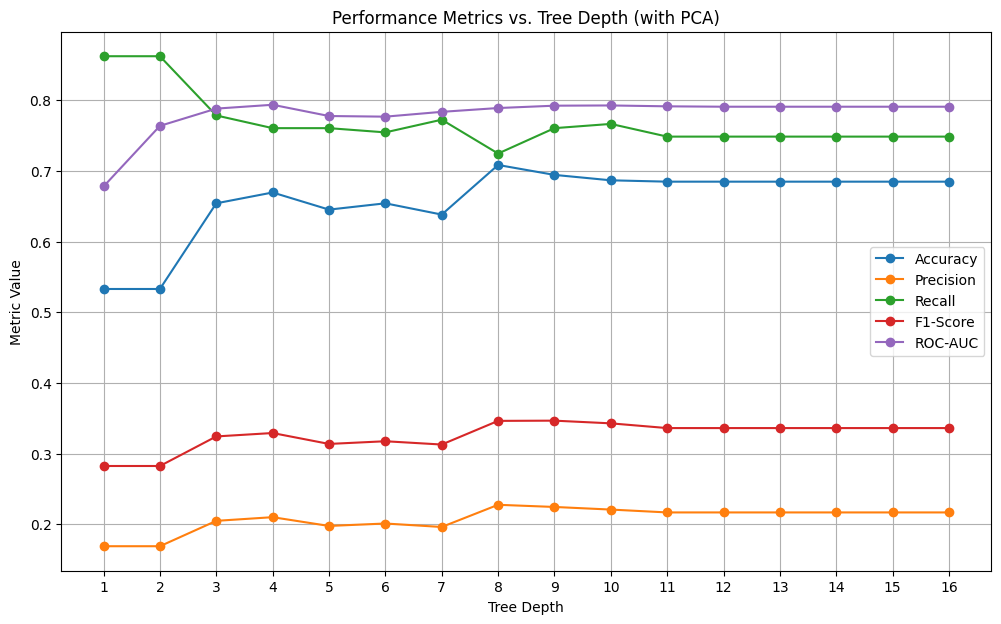

The tree depth with the best ROC-AUC using PCA is: 4
The ROC-AUC for the best tree using PCA is: 0.7936
The Accuracy for the best tree using PCA is: 0.6694


In [ ]:
trees_pca = []
all_metrics_pca = {
    'depth': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': []
}
tree_depths = [i for i in range(1,17)]

for d in tree_depths:
    dt_model_pca = DecisionTreeClassifier(
        max_depth=d,
        random_state=42,
        class_weight='balanced',
        min_samples_leaf=50,
    )
    dt_model_pca.fit(X_train_pca, y_train)
    trees_pca.append(dt_model_pca)

    y_pred = dt_model_pca.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    y_pred_proba_pca = dt_model_pca.predict_proba(X_test_pca)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba_pca)

    all_metrics_pca['depth'].append(d)
    all_metrics_pca['accuracy'].append(accuracy)
    all_metrics_pca['precision'].append(precision)
    all_metrics_pca['recall'].append(recall)
    all_metrics_pca['f1_score'].append(f1)
    all_metrics_pca['roc_auc'].append(roc_auc)

metrics_df_pca = pd.DataFrame(all_metrics_pca)

plt.figure(figsize=(12, 7))
plt.plot(metrics_df_pca['depth'], metrics_df_pca['accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df_pca['depth'], metrics_df_pca['precision'], marker='o', label='Precision')
plt.plot(metrics_df_pca['depth'], metrics_df_pca['recall'], marker='o', label='Recall')
plt.plot(metrics_df_pca['depth'], metrics_df_pca['f1_score'], marker='o', label='F1-Score')
plt.plot(metrics_df_pca['depth'], metrics_df_pca['roc_auc'], marker='o', label='ROC-AUC')

plt.title('Performance Metrics vs. Tree Depth (with PCA)')
plt.xlabel('Tree Depth')
plt.ylabel('Metric Value')
plt.xticks(tree_depths)
plt.grid(True)
plt.legend()
plt.show()

best_roc_auc_depth_pca = metrics_df_pca.loc[metrics_df_pca['roc_auc'].idxmax(), 'depth']
print(f"The tree depth with the best ROC-AUC using PCA is: {best_roc_auc_depth_pca}")
print(f"The ROC-AUC for the best tree using PCA is: {metrics_df_pca.loc[metrics_df_pca['roc_auc'].idxmax(), 'roc_auc']:.4f}")
print(f"The Accuracy for the best tree using PCA is: {metrics_df_pca.loc[metrics_df_pca['roc_auc'].idxmax(), 'accuracy']:.4f}")

We prefer not to sacrifice accuracy for recall, so we follow with the tree of depth 5 trained without PCA, which has a superior ROC-AUC either way. We can visualize it in particular.

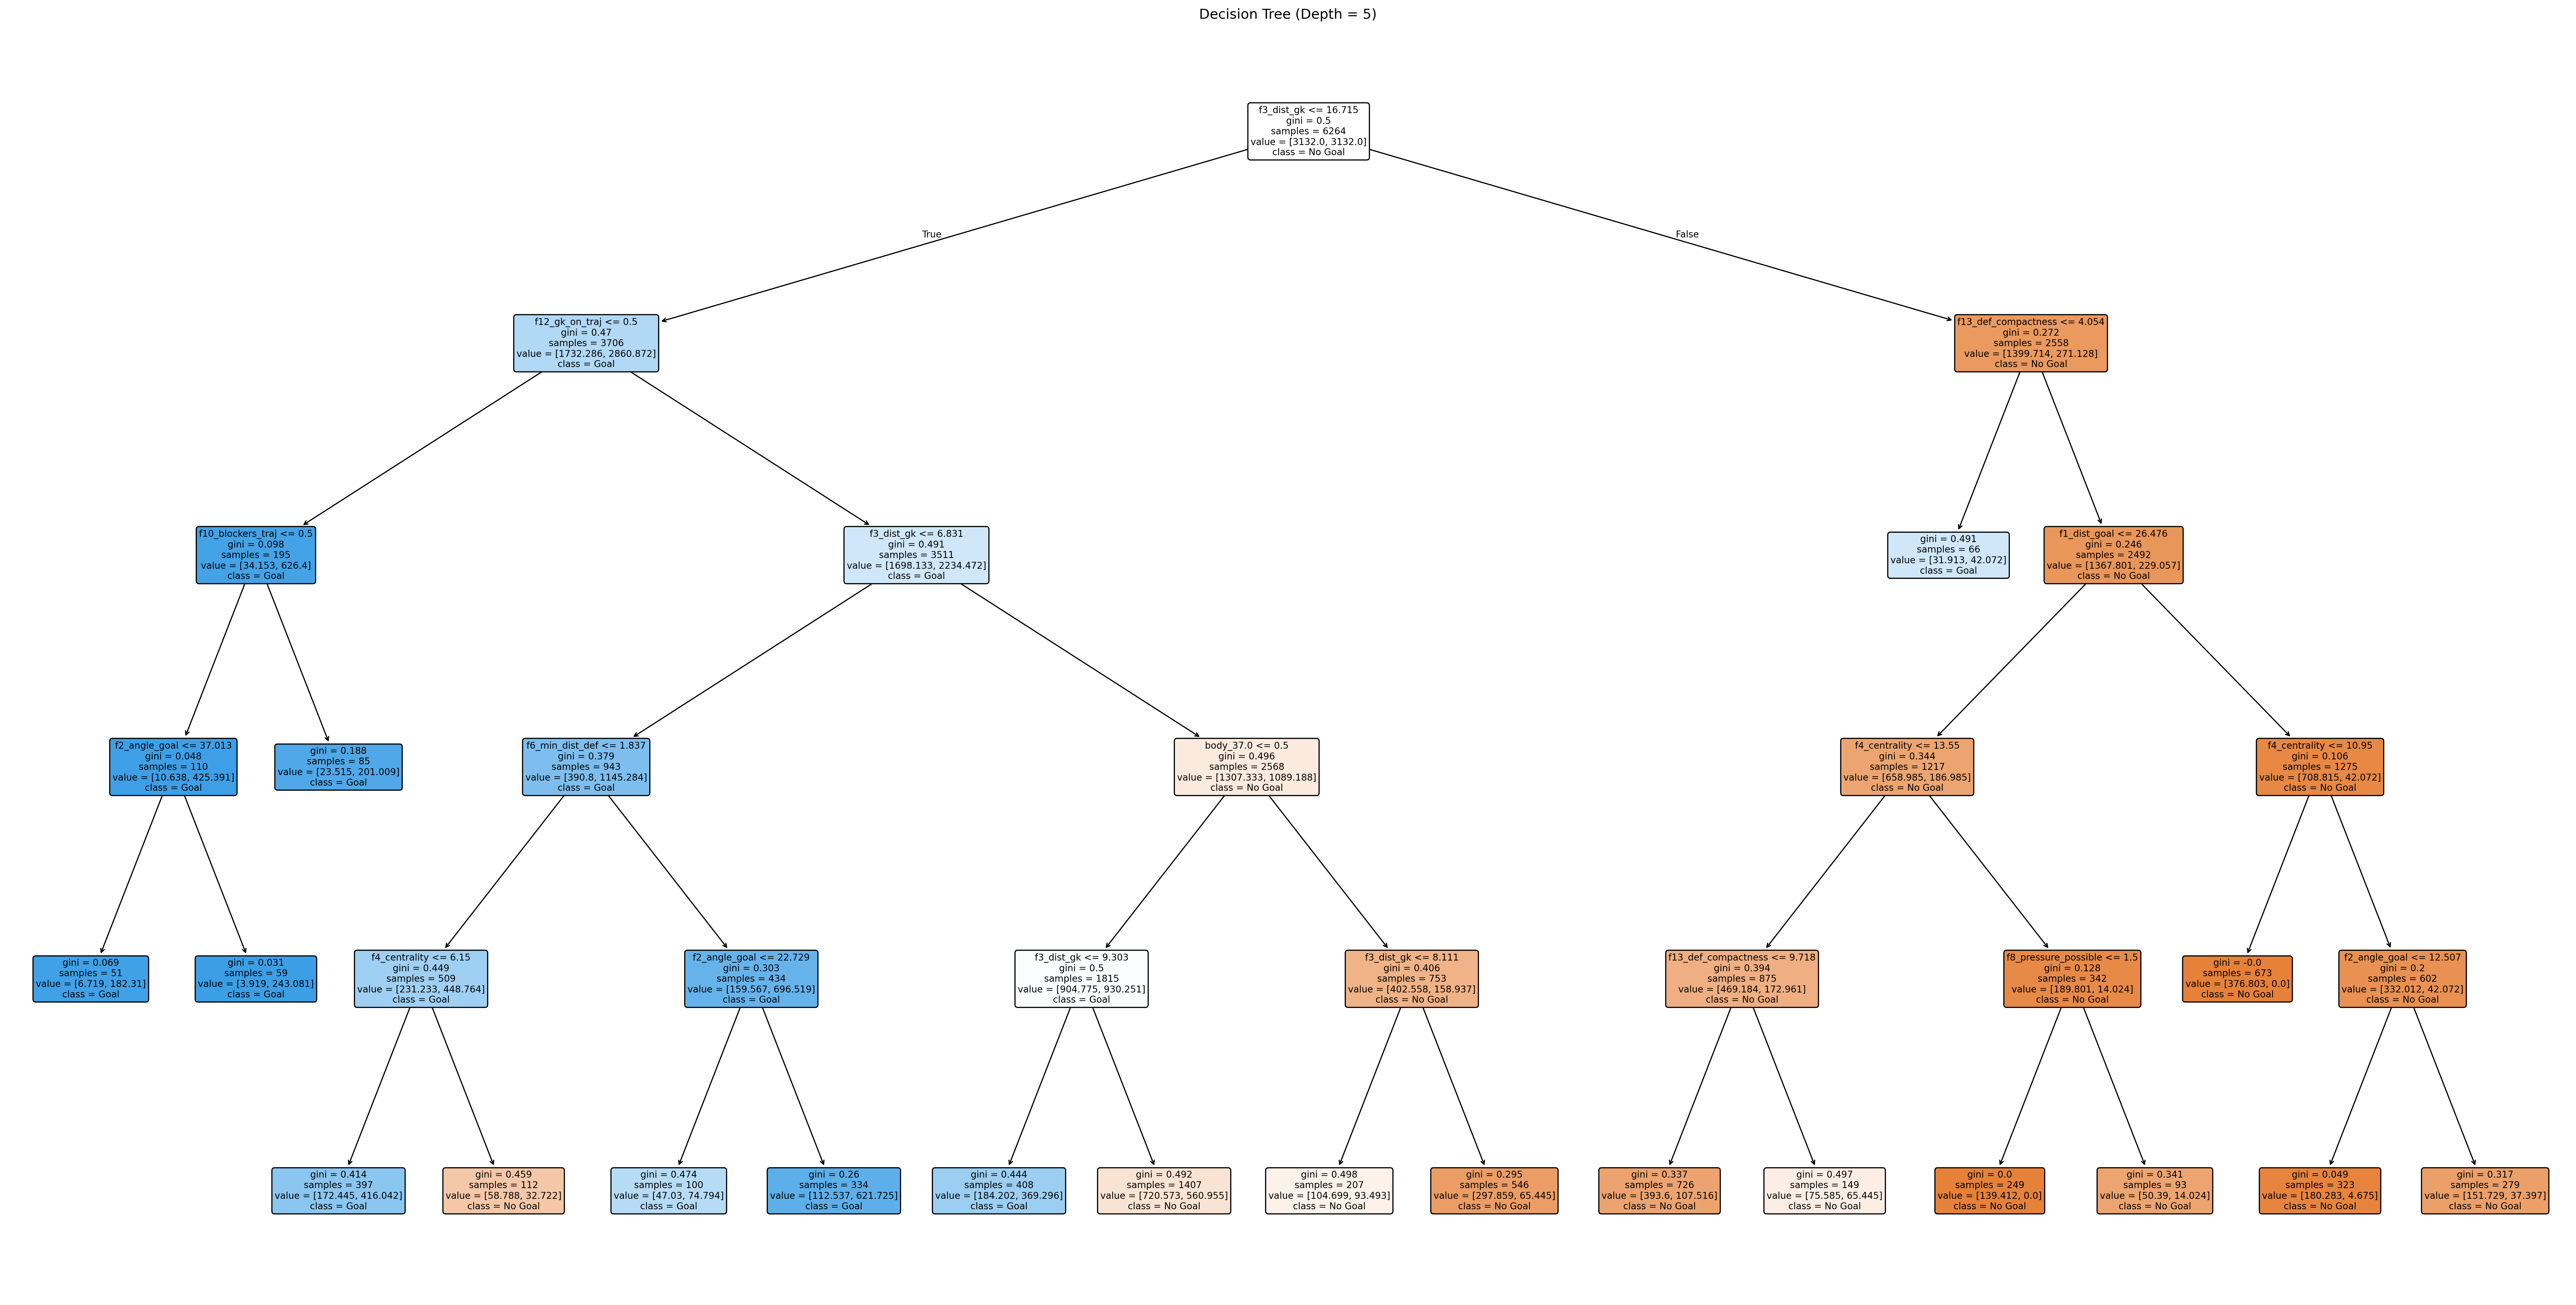

In [ ]:
best_tree = trees[best_roc_auc_depth - 1]

plt.figure(figsize=(40, 20), dpi=300)
plot_tree(best_tree, feature_names=X_train.columns.tolist(), class_names=['No Goal', 'Goal'], filled=True, rounded=True, fontsize=8)
plt.title(f'Decision Tree (Depth = {best_roc_auc_depth})')
plt.show()

We can also view its confusion matrix.

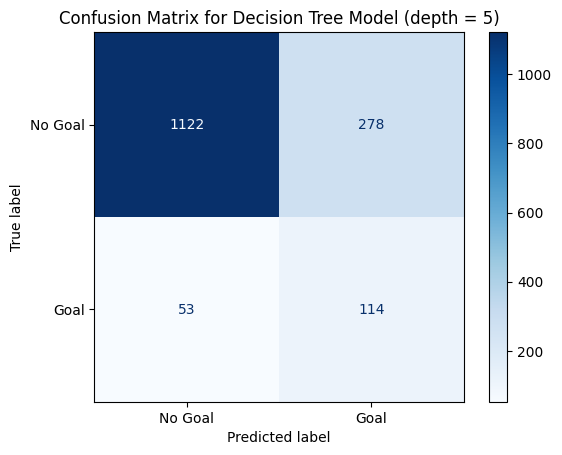


Model Performance Metrics:
Accuracy: 0.7888
Precision: 0.2908
Recall: 0.6826
F1-Score: 0.4079


{'accuracy': 0.7887683471601787,
 'precision': 0.29081632653061223,
 'recall': 0.6826347305389222,
 'f1_score': 0.407871198568873,
 'confusion_matrix': array([[1122,  278],
        [  53,  114]])}

In [ ]:
evaluate_and_display_confusion_matrix(
    model=best_tree,
    X_test_raw_df=X_test_original_for_loop,
    y_test_series=y_test,
    dropped_columns=zero_mean_columns,
    model_type='Decision Tree',
    depth=best_roc_auc_depth,
    print_and_plot=True
)

Finally, we can see the distribution of probabilities in comparison to StatsBomb's.

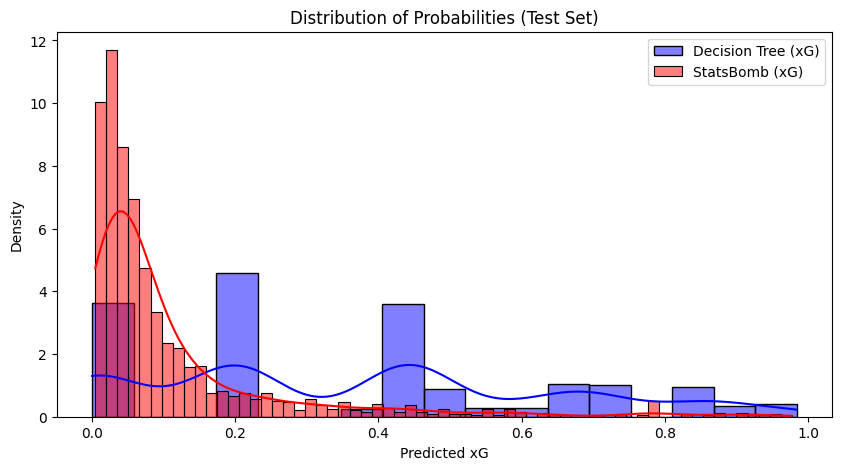

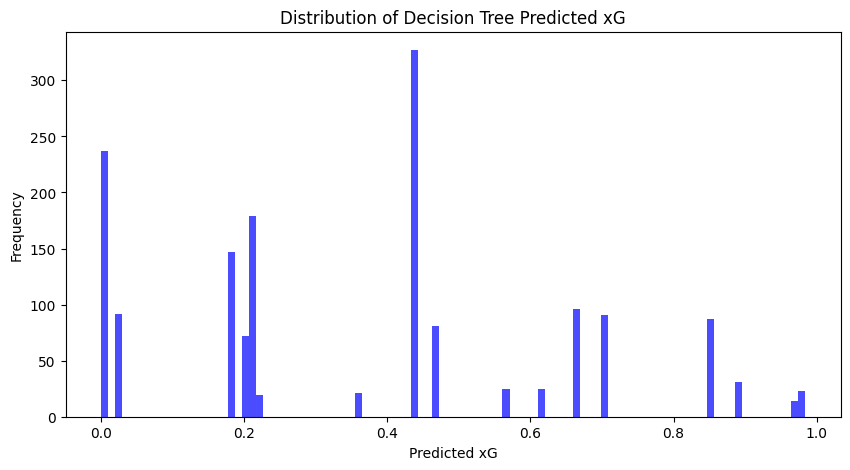

Min predicted xG (Decision Tree): 0.0
Max predicted xG (Decision Tree): 0.9841327839013728
Mean predicted xG (Decision Tree): 0.3635663226514412


In [ ]:
best_tree = trees[best_roc_auc_depth - 1]

y_pred_dt_proba = best_tree.predict_proba(X_test_processed_for_loop)[:, 1]

xg_baseline_test = xg.loc[X_test.index]
xg_baseline_test = xg_baseline_test['shot_statsbomb_xg'].values

plt.figure(figsize=(10,5))
sns.histplot(y_pred_dt_proba, color='blue', kde=True, stat='density', label='Decision Tree (xG)')
sns.histplot(xg_baseline_test, color='red', kde=True, stat='density', label='StatsBomb (xG)')
plt.title("Distribution of Probabilities (Test Set)")
plt.xlabel("Predicted xG")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.hist(y_pred_dt_proba, bins=100, color='blue', alpha=0.7)
plt.title("Distribution of Decision Tree Predicted xG")
plt.xlabel("Predicted xG")
plt.ylabel("Frequency")
plt.show()

print("Min predicted xG (Decision Tree):", np.min(y_pred_dt_proba))
print("Max predicted xG (Decision Tree):", np.max(y_pred_dt_proba))
print("Mean predicted xG (Decision Tree):", np.mean(y_pred_dt_proba))

We also check how well it performs as per the Brier Score. Not good!

In [ ]:
brier_score = brier_score_loss(y_test, y_pred_dt_proba)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.1752


## Conclusion

Decision Trees, by their nature, assign a probability to a data point based on the proportion of classes in the leaf node it falls into. This leads to a **'stepped' or 'blocky' probability distribution**, as seen in the histogram for `y_pred_dt_proba`. Each distinct bar or peak in the histogram corresponds to the probability assigned by a specific leaf node in the tree. Since the tree has a limited depth (e.g., 5 for the best model), there are a finite number of possible paths and thus a finite number of distinct probability outputs.

In contrast, the **StatsBomb xG model likely employs more complex statistical or machine learning techniques** that can produce much smoother, more continuous probability estimates across the entire range from 0 to 1. This is evident in the `xg_baseline_test` histogram, which typically shows a more continuous curve, reflecting a finer-grained assessment of shot likelihood.

### Why a Decision Tree might not be the best fit for an xG model:

1.  **Lack of Granularity in Probability Estimates**: The core issue lies in the discrete nature of Decision Tree outputs. An Expected Goals (xG) model aims to predict a *continuous probability* for a shot resulting in a goal. A Decision Tree's output, being piecewise constant, simplifies this complex continuous problem into a series of discrete probability bins. This is a fundamental mismatch, as real-world shot probabilities are highly nuanced.

2.  **Poor Calibration (High Brier Score)**: The Brier Score directly quantifies the accuracy of probabilistic predictions. A lower Brier Score indicates better calibration, meaning that when the model predicts a 20% chance of a goal, approximately 20% of such shots actually result in goals. A Brier Score of **0.1752** for the Decision Tree model indicates that the model's predicted probabilities are poorly calibrated. It means the numerical probabilities output by the Decision Tree do not reliably reflect the true likelihood of a goal. For an xG model, calibration is paramount, and the Decision Tree falls short here.

3.  **Limited Expressiveness for Complex Relationships**: Generating accurate xG requires modeling intricate, often non-linear relationships between many features (distance to goal, angle to goal, number of defenders, goalkeeper position, etc.). While Decision Trees can capture some non-linearity by partitioning the feature space, they do so with axis-parallel splits. More sophisticated models can often learn these complex interactions more flexibly and accurately, leading to better-calibrated and more continuous probability estimates.

In summary, while Decision Trees are interpretable and can achieve decent classification metrics (like accuracy or recall), their inherent design makes them less ideal for problems requiring highly granular and well-calibrated probability predictions, such as Expected Goals. The significant difference in probability distribution shape and the high Brier Score strongly support this conclusion.

## Addendum: distribution and Brier Score of decision tree with PCA

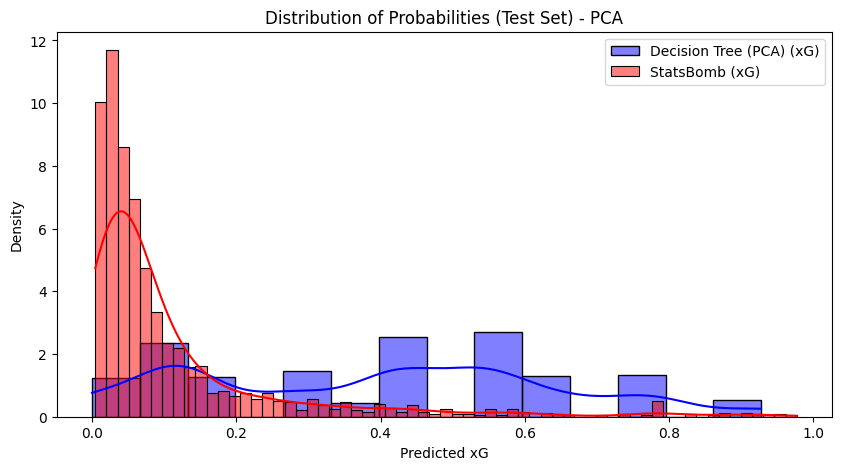

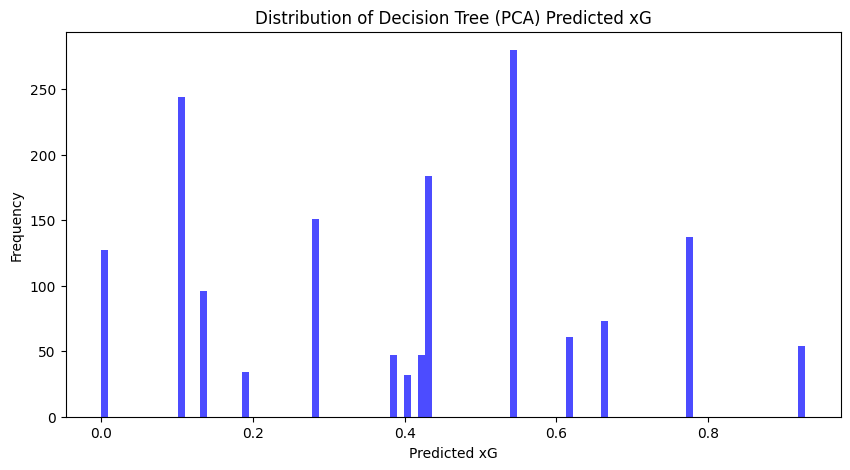

Min predicted xG (Decision Tree with PCA): 0.0
Max predicted xG (Decision Tree with PCA): 0.9278898506389252
Mean predicted xG (Decision Tree with PCA): 0.3909396784481525


In [ ]:
best_tree_pca = trees_pca[best_roc_auc_depth_pca - 1]

y_pred_dt_proba_pca = best_tree_pca.predict_proba(X_test_pca)[:, 1]

# xg_baseline_test is already defined from the previous cells
# xg_baseline_test = xg.loc[X_test.index]
# xg_baseline_test = xg_baseline_test['shot_statsbomb_xg'].values

plt.figure(figsize=(10,5))
sns.histplot(y_pred_dt_proba_pca, color='blue', kde=True, stat='density', label='Decision Tree (PCA) (xG)')
sns.histplot(xg_baseline_test, color='red', kde=True, stat='density', label='StatsBomb (xG)')
plt.title("Distribution of Probabilities (Test Set) - PCA")
plt.xlabel("Predicted xG")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.hist(y_pred_dt_proba_pca, bins=100, color='blue', alpha=0.7)
plt.title("Distribution of Decision Tree (PCA) Predicted xG")
plt.xlabel("Predicted xG")
plt.ylabel("Frequency")
plt.show()

print("Min predicted xG (Decision Tree with PCA):", np.min(y_pred_dt_proba_pca))
print("Max predicted xG (Decision Tree with PCA):", np.max(y_pred_dt_proba_pca))
print("Mean predicted xG (Decision Tree with PCA):", np.mean(y_pred_dt_proba_pca))

In [ ]:
brier_score_pca = brier_score_loss(y_test, y_pred_dt_proba_pca)
print(f"Brier Score (Decision Tree with PCA): {brier_score_pca:.4f}")

Brier Score (Decision Tree with PCA): 0.1855
